### ITSM Ticket automation using RNN


1. NLP using LSTM to the Description of the problem
2. Run RNN for the attributes

In [1]:
import keras 
import numpy as np
from keras.preprocessing.text import Tokenizer
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Flatten
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [2]:
data = pd.read_csv('/Users/jairomelo/Desktop/ML/YORK/ML1030/Capstone Project/incident 05-09-19.csv', encoding = "cp1252")

### Actions:
1. Balance the data sample.
2. Description has null values; we will use short description in case of missing description, and filter any record where no description nor short description is provided
3. Removing any occurence where 

In [3]:
# replacing na values in description with the Short Description 
data["Description"].fillna(data["Short_Description"], inplace = True) 
data = data.dropna(subset = ['Priority'])


In [4]:
#Cleaning Description using short description for observations recorded by Netcool Alerting tool
data['Description'] = data.apply(
    lambda row: row.Short_Description if 'Netcool Fields:' in row.Description else row.Description ,  axis = 1)

In [5]:
data.head()

,Number,Description,Short_Description,Caller,Priority,Category,Sub_Category,Urgency,Impact,Configuration_item,...,Assignment_group,State.1,Resolution_category,Site,Resolved_by_group,Resolved_by,KCS_solution,CI_regions,Created,Resolved
0,INC000017612819,SIMS blank page when open with IE\r\n??IE ??S...,SIMS blank page,YUTONG ZHOU (152062324),Priority 4,Software,Website,Low,Limited,SIMS LATAM,...,GLOBAL SERVICE DESK,Closed Complete,Change Implementation,NaN,GLOBAL SERVICE DESK,JING HUANG (645010504),KB000010025934,LATAM,2017-11-12 21:03,2017-11-12 21:03
1,INC000020585404,"For dim_slt_id=203, dim_task_id=1658 exited wi...",TASK_STATUS - SLT ID 203,AGGRIFY SLT AUTOMATION (702303384),Priority 4,Application,Job Failure,Low,Limited,MENTOR BI SALES ANALYTICS,...,DATA AND ANALYTICS RR LTI,Closed Complete,Job Failure,NA US NJ RARITAN,DATA AND ANALYTICS RR LTI,DILIP KHANDAI (643026421),KB000010080602,NaN,2019-08-04 3:30,2019-08-06 6:39
2,INC000020692831,"For DIM_SLT_ID=203, following task(s) violated...",TASK_END_DELAY violated for DIM_SLT_ID 203,AGGRIFY SLT AUTOMATION (702303384),Priority 4,Application,Poor performance,Low,Limited,MENTOR BI SALES ANALYTICS,...,DATA AND ANALYTICS RR LTI,Draft,Job Failure,NA US NJ RARITAN,DATA AND ANALYTICS RR LTI,DILIP KHANDAI (643026421),KB000010081617,NaN,2019-08-24 2:15,2019-08-28 4:55
3,INC000017000450,??????,Software - J&J business applications: Unavaila...,ZHIYU ZHANG (85434123),Priority 4,Software,Website,Low,Localized,JJMC IPOWER -- PROF ED HCP MASTER DATABASE,...,AS MEDICAL APP CHINA L2,Closed Complete,User Access / Permission,ASPAC CN SHANGHAI,AS MEDICAL APP CHINA L2,WEI WANG (702020246),NaN,ASPAC,2017-06-27 3:26,2017-06-29 2:04
4,INC000017291067,> DS huddle Login issue,> DS huddle Login issue,SEAN FOLEY (702113126),Priority 4,Software,Desktop Software,Low,Localized,DS MOBILE,...,GLOBAL SERVICE DESK,Closed Complete,User Access / Permission,NA US NJ RARITAN,GLOBAL SERVICE DESK,ABEGAIL COMON (645001723),KB000010027981,NaN,2017-08-31 10:34,2017-08-31 14:36


In [6]:
data.Priority.value_counts()

Priority 4    33383
Priority 3    22495
Priority 2      194
Priority 1        4
Name: Priority, dtype: int64

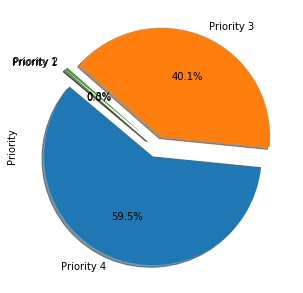

In [7]:
chart=data.Priority.value_counts()
explode = (0.1, 0.1, 0.1, 0.1)
plot = chart.plot.pie(y='Priority', figsize=(5, 5), explode=explode, subplots=True, autopct='%1.1f%%', shadow=True, startangle=140)


In [8]:
from sklearn.utils import resample

df_1 = data[data.Priority=='Priority 4']
df_2 = data[data.Priority=='Priority 3']

df_1_upsampled = resample(df_1, 
                                 replace=True,     # sample with replacement
                                 n_samples=22495,  # to match majority class
                                 random_state=123) # reproducible results

df_2_upsampled = resample(df_2, 
                                 replace=True,     # sample with replacement
                                 n_samples=22495,  # to match majority class
                                 random_state=123) # reproducible results



# Combine majority class with upsampled minority class
data = pd.concat([df_1_upsampled, df_2_upsampled])

In [9]:
data.Priority.value_counts()

Priority 3    22495
Priority 4    22495
Name: Priority, dtype: int64

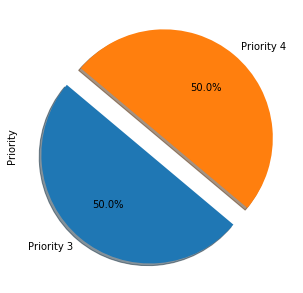

In [10]:
chart=data.Priority.value_counts()
explode = (0.1, 0.1)
plot = chart.plot.pie(y='Priority', figsize=(5, 5), explode=explode, subplots=True, autopct='%1.1f%%', shadow=True, startangle=140)


In [11]:
data['target_prt'] = data.Priority.astype('category').cat.codes

In [12]:
labels_prt = data.Priority.astype('category').cat.categories

In [13]:
df = pd.DataFrame(labels_prt) 
df.to_csv ('/Users/jairomelo/Desktop/ML/YORK/ML1030/Capstone Project/labels_prt.csv')

In [14]:
data.head()

,Number,Description,Short_Description,Caller,Priority,Category,Sub_Category,Urgency,Impact,Configuration_item,...,State.1,Resolution_category,Site,Resolved_by_group,Resolved_by,KCS_solution,CI_regions,Created,Resolved,target_prt
24537,INC000020572802,"For dim_slt_id=2316, following tasks violated ...",TASK_END_DELAY - SLT ID 2316,AGGRIFY SLT AUTOMATION (702303384),Priority 4,Application,Poor performance,Low,Limited,DEPUY SYNTHES – US – BI – QLIK,...,Closed Complete,Connectivity,NA US NJ RARITAN,DATA AND ANALYTICS RR LTI,MRUGANG PURAO (643021133),KB000010080053,NaN,2019-08-01 4:00,2019-08-02 8:42,1
48264,INC000019357291,Control-M: 32_NAP_NONSAP - Event: JOB NOT OK A...,Control-M: 32_NAP_NONSAP - Event: JOB NOT OK A...,NETCOOL AGENT (702116225),Priority 4,Application,Job Failure,Low,Limited,ONEMD D&A CLINICAL DIA - PROD,...,Closed Complete,Physical environmental failure,NaN,DATA AND ANALYTICS RR TCS,ALOK DAS (643014408),KB000010047671,GLOBAL,2018-11-19 19:15,2018-11-22 2:17,1
30708,INC000018820683,I have the required user acess rights to AWSAD...,Connectivity issue with EC2 server,DIOGO BALTAZAR (702260239),Priority 4,Software,Enterprise software,Low,Limited,ONEMD COMMERCIAL ANALYTICS - PROD,...,Closed Complete,User knowledge or training error,Lagoas Park,AS_MDD_EMEA_COMMANLYCS_L2,SNEHAJIT BISWAS (643010176),KB000010041252,EMEA,2018-07-31 11:01,2018-08-02 10:21,1
24077,INC000020409726,When did this issue begin?:\r\n\r\nWho is this...,UCN is mapped to the default unknown 9999998 i...,JACOB VEATCH (196099),Priority 4,Application,Data Issue,Medium,Limited,ONEMD COMMERCIAL DATA WAREHOUSE - PROD,...,Closed Complete,Data Issue,NA US IN WARSAW,DATA AND ANALYTICS RR LTI,JANARDHANAN DHANDAPANI KUTTY (643019823),KB000010076928,NaN,2019-06-28 15:08,2019-07-10 21:06,1
12562,INC000017608615,GFS-FP&A-FINANCIAL PLANNING TM1 Finance GRM TM...,Software - J&J business applications: Data mis...,JONIZEN ABING (152026114),Priority 4,Software,Enterprise software,Medium,Limited,GFS-FP&A-FINANCIAL PLANNING TM1,...,Closed Complete,Data Issue,ASPAC PH PARANAQUE,GFS-FP&A COE TM1,JONATHAN YAU (1043412),NaN,GLOBAL,2017-11-10 14:01,2017-11-13 10:28,1


In [15]:
data['num_words'] = data['Description'].apply(lambda x : len(x.split()))

In [16]:
bins=[0,50,75, np.inf]
data['bins']=pd.cut(data.num_words, bins=[0,10,30,60,130, np.inf], labels=['0-10', '10-30', '30-60','60-130' ,'>130'])


In [17]:
word_distribution = data.groupby('bins').size().reset_index().rename(columns={0:'counts'})

In [18]:
word_distribution.head()

,bins,counts
0,0-10,10109
1,10-30,19155
2,30-60,9697
3,60-130,5106
4,>130,923


Text(0.5, 1.0, 'Word distribution per bin')

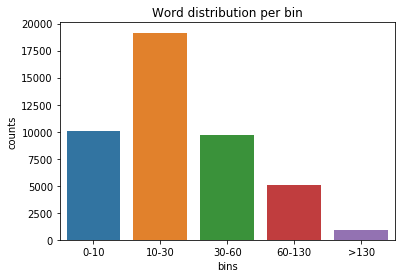

In [19]:
sns.barplot(x='bins', y='counts', data=word_distribution).set_title("Word distribution per bin")

In [20]:
data.head()

,Number,Description,Short_Description,Caller,Priority,Category,Sub_Category,Urgency,Impact,Configuration_item,...,Site,Resolved_by_group,Resolved_by,KCS_solution,CI_regions,Created,Resolved,target_prt,num_words,bins
24537,INC000020572802,"For dim_slt_id=2316, following tasks violated ...",TASK_END_DELAY - SLT ID 2316,AGGRIFY SLT AUTOMATION (702303384),Priority 4,Application,Poor performance,Low,Limited,DEPUY SYNTHES – US – BI – QLIK,...,NA US NJ RARITAN,DATA AND ANALYTICS RR LTI,MRUGANG PURAO (643021133),KB000010080053,NaN,2019-08-01 4:00,2019-08-02 8:42,1,9,0-10
48264,INC000019357291,Control-M: 32_NAP_NONSAP - Event: JOB NOT OK A...,Control-M: 32_NAP_NONSAP - Event: JOB NOT OK A...,NETCOOL AGENT (702116225),Priority 4,Application,Job Failure,Low,Limited,ONEMD D&A CLINICAL DIA - PROD,...,NaN,DATA AND ANALYTICS RR TCS,ALOK DAS (643014408),KB000010047671,GLOBAL,2018-11-19 19:15,2018-11-22 2:17,1,18,10-30
30708,INC000018820683,I have the required user acess rights to AWSAD...,Connectivity issue with EC2 server,DIOGO BALTAZAR (702260239),Priority 4,Software,Enterprise software,Low,Limited,ONEMD COMMERCIAL ANALYTICS - PROD,...,Lagoas Park,AS_MDD_EMEA_COMMANLYCS_L2,SNEHAJIT BISWAS (643010176),KB000010041252,EMEA,2018-07-31 11:01,2018-08-02 10:21,1,44,30-60
24077,INC000020409726,When did this issue begin?:\r\n\r\nWho is this...,UCN is mapped to the default unknown 9999998 i...,JACOB VEATCH (196099),Priority 4,Application,Data Issue,Medium,Limited,ONEMD COMMERCIAL DATA WAREHOUSE - PROD,...,NA US IN WARSAW,DATA AND ANALYTICS RR LTI,JANARDHANAN DHANDAPANI KUTTY (643019823),KB000010076928,NaN,2019-06-28 15:08,2019-07-10 21:06,1,40,30-60
12562,INC000017608615,GFS-FP&A-FINANCIAL PLANNING TM1 Finance GRM TM...,Software - J&J business applications: Data mis...,JONIZEN ABING (152026114),Priority 4,Software,Enterprise software,Medium,Limited,GFS-FP&A-FINANCIAL PLANNING TM1,...,ASPAC PH PARANAQUE,GFS-FP&A COE TM1,JONATHAN YAU (1043412),NaN,GLOBAL,2017-11-10 14:01,2017-11-13 10:28,1,17,10-30


In [21]:
num_class_prt = len(np.unique(data.Priority.values))
y_prt = data['target_prt'].values


## Topic Modelling

In [22]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import numpy as np
import pandas as pd
import re
import warnings
from sklearn.metrics import confusion_matrix
#Visualisation
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from IPython.display import display
#from mpl_toolkits.basemap import Basemap
from wordcloud import WordCloud, STOPWORDS

#nltk
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize

In [23]:
data['Description'] = data['Description'].astype(str)

In [24]:
type(data['Description'])

pandas.core.series.Series

In [25]:
data_description = data.Description.values

In [26]:
type(data_description)

numpy.ndarray

In [27]:
#cv = # Initialize a CountVectorizer object: count_vectorizer
count_vec = CountVectorizer(stop_words="english", analyzer='word', 
                            ngram_range=(1, 1), max_df=1, min_df=1, max_features=None)

# convert text data into term-frequency matrix
data_description = count_vec.fit_transform(data_description)




tfidf_transformer = TfidfTransformer()

# convert term-frequency matrix into tf-idf
tfidf_matrix = tfidf_transformer.fit_transform(data_description)

# create dictionary to find a tfidf word each word
word2tfidf = dict(zip(count_vec.get_feature_names(), tfidf_transformer.idf_))

for word, score in word2tfidf.items():
    print(word, score)

000000000 11.021070568189845
000000000000019445 11.021070568189845
000000000000410989 11.021070568189845
000000000000410990 11.021070568189845
000000000000413030 11.021070568189845
000000000000413031 11.021070568189845
000000000000415798 11.021070568189845
000000000000416209 11.021070568189845
000000000000417710 11.021070568189845
000000000015061379 11.021070568189845
000000000019804817 11.021070568189845
000000000019804824 11.021070568189845
000000000043309730 11.021070568189845
000000000100369500 11.021070568189845
000000000304882800 11.021070568189845
000000000510007127 11.021070568189845
000000000523062000 11.021070568189845
000000000523062500 11.021070568189845
000000000523063500 11.021070568189845
000000000523065500 11.021070568189845
000000000527806000 11.021070568189845
000000000529447900 11.021070568189845
000000000529448000 11.021070568189845
000000010000000d0000000d 11.021070568189845
0000000376 11.021070568189845
0000002265 11.021070568189845
000000_0 11.021070568189845
000

18042 11.021070568189845
18060 11.021070568189845
18061 11.021070568189845
18062 11.021070568189845
18063 11.021070568189845
18064 11.021070568189845
18065 11.021070568189845
18066 11.021070568189845
18067 11.021070568189845
18068 11.021070568189845
18069 11.021070568189845
18070 11.021070568189845
18072 11.021070568189845
18073 11.021070568189845
18074 11.021070568189845
1810 11.021070568189845
181k 11.021070568189845
18285_shikora_sa 11.021070568189845
182907 11.021070568189845
18299478995 11.021070568189845
18304g 11.021070568189845
18370 11.021070568189845
184043 11.021070568189845
184282204 11.021070568189845
1851 11.021070568189845
18510 11.021070568189845
18510920656 11.021070568189845
1856498339757 11.021070568189845
1858 11.021070568189845
18646 11.021070568189845
18652 11.021070568189845
18658 11.021070568189845
186c65ee 11.021070568189845
18734 11.021070568189845
1879961555 11.021070568189845
18823 11.021070568189845
18841377 11.021070568189845
1886 11.021070568189845
188e8c

3i3458 11.021070568189845
3i3501 11.021070568189845
3i3502 11.021070568189845
3i3505 11.021070568189845
3i3507 11.021070568189845
3i3508 11.021070568189845
3i3511 11.021070568189845
3i3513 11.021070568189845
3i3514 11.021070568189845
3i3879 11.021070568189845
3i4121 11.021070568189845
3i4853 11.021070568189845
3i4959 11.021070568189845
3i4972 11.021070568189845
3i4975 11.021070568189845
3i4976 11.021070568189845
3i4978 11.021070568189845
3i5377 11.021070568189845
3i5437 11.021070568189845
3i5641 11.021070568189845
3i5815 11.021070568189845
3i5832 11.021070568189845
3i6055 11.021070568189845
3i6216 11.021070568189845
3i6217 11.021070568189845
3i6248 11.021070568189845
3i6612 11.021070568189845
3i8234 11.021070568189845
3i8547 11.021070568189845
3j1474 11.021070568189845
3j2042 11.021070568189845
3j5223 11.021070568189845
3j5480 11.021070568189845
3j7096 11.021070568189845
3j844 11.021070568189845
3k 11.021070568189845
3n2882 11.021070568189845
3n3422 11.021070568189845
3n5557 11.0210705

61977 11.021070568189845
619mm 11.021070568189845
61k 11.021070568189845
6210000 11.021070568189845
6210001 11.021070568189845
6210002 11.021070568189845
6210003 11.021070568189845
6210004 11.021070568189845
6210005 11.021070568189845
6210006 11.021070568189845
6210007 11.021070568189845
6210008 11.021070568189845
6210009 11.021070568189845
6212 11.021070568189845
62131 11.021070568189845
62133 11.021070568189845
6215 11.021070568189845
62194 11.021070568189845
6220000 11.021070568189845
6220001 11.021070568189845
6220002 11.021070568189845
6220003 11.021070568189845
6220004 11.021070568189845
6220005 11.021070568189845
6220006 11.021070568189845
6220007 11.021070568189845
6220008 11.021070568189845
6220009 11.021070568189845
6230000 11.021070568189845
6230001 11.021070568189845
6230002 11.021070568189845
6230003 11.021070568189845
6230004 11.021070568189845
6230005 11.021070568189845
6230006 11.021070568189845
6230007 11.021070568189845
6230008 11.021070568189845
6230009 11.0210705681

arnaud 11.021070568189845
arquiovos 11.021070568189845
arrangements 11.021070568189845
arreaza 11.021070568189845
arrengement 11.021070568189845
arrival 11.021070568189845
articulate 11.021070568189845
artikel 11.021070568189845
artikels 11.021070568189845
artisynunk 11.021070568189845
arty 11.021070568189845
arty5l 11.021070568189845
artyom 11.021070568189845
aruiz22 11.021070568189845
arun 11.021070568189845
arunachalam 11.021070568189845
arundinesh 11.021070568189845
arvide 11.021070568189845
arx 11.021070568189845
ary_report_0_1 11.021070568189845
aryal 11.021070568189845
as_mdd_emea_commanlycs_l3 11.021070568189845
asa 11.021070568189845
asami2 11.021070568189845
asapac 11.021070568189845
asbpc00 11.021070568189845
ascdashboard 11.021070568189845
ascending 11.021070568189845
ascent 11.021070568189845
ascmarketdynamics 11.021070568189845
asco 11.021070568189845
ascreenshot 11.021070568189845
asdw_stg_prob_mgmt_srvc 11.021070568189845
asdwincidentmanagementmonthlydashboardnon 11.021

d4bf19a2d667 11.021070568189845
d5407f7a508d4c5f8050db2cecfba177 11.021070568189845
d6 11.021070568189845
d65aaedc 11.021070568189845
d69c9bc5 11.021070568189845
d6b36aa4192241e3b4b021bb466fdf3c 11.021070568189845
d7377355 11.021070568189845
d77ecf312ea5 11.021070568189845
d_customer 11.021070568189845
d_dm_territory_alnmt_ship_to_dim 11.021070568189845
d_end_customer_dist 11.021070568189845
d_product 11.021070568189845
d_sale_recognition_calendar 11.021070568189845
d_sales_force 11.021070568189845
d_sales_org 11.021070568189845
da65 11.021070568189845
da9089e9 11.021070568189845
daatbase 11.021070568189845
dac 11.021070568189845
dacogen 11.021070568189845
dada 11.021070568189845
dahbl22_gnq_unx_ged_qa_hubble_masters 11.021070568189845
dahbl32_gnp_unx_ged_p 11.021070568189845
dahbl32_gnp_unx_ged_pro 11.021070568189845
dahbl32_gnp_unx_ged_prod 11.021070568189845
dahbl32_gnp_unx_ged_prod_hubble 11.021070568189845
dahbl32_gnp_unx_ged_prod_hubble_maste 11.021070568189845
dahbl32_unx_gnp_pr

gco 11.021070568189845
gcs1o32_tdl_gnp_lnx_python_np_brigh 11.021070568189845
gcs1o32_tdl_gnp_lnx_talend_nq_gcso_gpa_ld 11.021070568189845
gcso_bi_read 11.021070568189845
gcso_dev_read 11.021070568189845
gctt 11.021070568189845
gddmsummary 11.021070568189845
gdi 11.021070568189845
gds_latam_daily 11.021070568189845
gearbeitet 11.021070568189845
gebeld 11.021070568189845
gebietskategorie 11.021070568189845
gebietskategorien 11.021070568189845
gebruers 11.021070568189845
gebruiken 11.021070568189845
gebruikersaccount 11.021070568189845
gecreerd 11.021070568189845
gedownloadet 11.021070568189845
gee 11.021070568189845
geet 11.021070568189845
geetanjali 11.021070568189845
geetha 11.021070568189845
gegangen 11.021070568189845
gegenereerd 11.021070568189845
gelieve 11.021070568189845
gell 11.021070568189845
gels 11.021070568189845
gemaakt 11.021070568189845
gembin 11.021070568189845
gemcibine 11.021070568189845
gemcin 11.021070568189845
gemcit 11.021070568189845
gemcitabine 11.02107056818984

jjcus_gfdw_qs_jde_prd 11.021070568189845
jjcus_itsp_incrementalpmxfiles 11.021070568189845
jjcus_itsp_pmx_businesscase_cloudera 11.021070568189845
jjcus_p2p 11.021070568189845
jjcus_p2p_b2b 11.021070568189845
jjcus_tedw_core 11.021070568189845
jjdata 11.021070568189845
jjddc 11.021070568189845
jjdes 11.021070568189845
jjds 11.021070568189845
jjeds_ssis 11.021070568189845
jjedsstage 11.021070568189845
jjgomezbarrado 11.021070568189845
jjhcs 11.021070568189845
jjids 11.021070568189845
jjimu 11.021070568189845
jjkk 11.021070568189845
jjmcu 11.021070568189845
jjmi 11.021070568189845
jjmp 11.021070568189845
jjn 11.021070568189845
jjpau 11.021070568189845
jjprice 11.021070568189845
jjrc 11.021070568189845
jjtqualitymetrics 11.021070568189845
jjukawards 11.021070568189845
jjvcinsight 11.021070568189845
jjvs 11.021070568189845
jk_jims 11.021070568189845
jkielar 11.021070568189845
jkim244 11.021070568189845
jkt99300 11.021070568189845
jlai18 11.021070568189845
jlidholm 11.021070568189845
jlima2

o0ytkqpt 11.021070568189845
o1d 11.021070568189845
o1da 11.021070568189845
oben 11.021070568189845
obi 11.021070568189845
obj_crncy 11.021070568189845
obj_curr 11.021070568189845
obj_mdv 11.021070568189845
obj_nm 11.021070568189845
objectid 11.021070568189845
obstetricia 11.021070568189845
obstruction 11.021070568189845
obtainrawinternalconnection 11.021070568189845
obtendo 11.021070568189845
ocasio 11.021070568189845
occasion 11.021070568189845
occasional 11.021070568189845
occasionally 11.021070568189845
occassionally 11.021070568189845
occassions 11.021070568189845
occupational 11.021070568189845
occupying 11.021070568189845
occurances 11.021070568189845
occures 11.021070568189845
occurringas 11.021070568189845
ochernys 11.021070568189845
oct17 11.021070568189845
oculares 11.021070568189845
ocurs 11.021070568189845
od 11.021070568189845
oda 11.021070568189845
odf 11.021070568189845
odg 11.021070568189845
odl 11.021070568189845
ods_cust_order 11.021070568189845
oeffnen 11.02107056818

rol 11.021070568189845
roland 11.021070568189845
role_evidence 11.021070568189845
rolefile 11.021070568189845
rolland 11.021070568189845
roller 11.021070568189845
rollout 11.021070568189845
rom 11.021070568189845
romanous 11.021070568189845
rommy 11.021070568189845
romresourcename 11.021070568189845
ron 11.021070568189845
rootfolder 11.021070568189845
rootrequestfilter 11.021070568189845
rootresourceclassesrule 11.021070568189845
ros 11.021070568189845
rosalind 11.021070568189845
rosano 11.021070568189845
rosario 11.021070568189845
rossem_ir_sales 11.021070568189845
rossioli 11.021070568189845
rosto 11.021070568189845
rotated 11.021070568189845
roth 11.021070568189845
rothwell 11.021070568189845
roundings 11.021070568189845
roundy 11.021070568189845
routen 11.021070568189845
routeno 11.021070568189845
router 11.021070568189845
row_5 11.021070568189845
row_cnt 11.021070568189845
royalty_reports_extraction 11.021070568189845
rp 11.021070568189845
rp0625 11.021070568189845
rp2750 11.02107

toolbox 11.021070568189845
top20 11.021070568189845
topline 11.021070568189845
topofficine 11.021070568189845
topolinaya 11.021070568189845
topup_ho_dashboard 11.021070568189845
tornar 11.021070568189845
torp 11.021070568189845
toscana 11.021070568189845
toshikazu 11.021070568189845
tot_nt_tr_sls_sys 11.021070568189845
total_visit__c 11.021070568189845
totaltime 11.021070568189845
totalus 11.021070568189845
totaly 11.021070568189845
totem 11.021070568189845
totems 11.021070568189845
tots 11.021070568189845
touati 11.021070568189845
touchpointe 11.021070568189845
touppercase 11.021070568189845
tournois 11.021070568189845
touts 11.021070568189845
tower 11.021070568189845
townsville 11.021070568189845
towork 11.021070568189845
tox11617 11.021070568189845
toy 11.021070568189845
tp_estab_descr 11.021070568189845
tpdetailreport 11.021070568189845
tpereir1 11.021070568189845
tpeter25 11.021070568189845
tpt 11.021070568189845
tr0114 11.021070568189845
tr0116 11.021070568189845
tr0120 11.021070

In [28]:
term_frequency = count_vec.vocabulary_
type(term_frequency)

dict

In [29]:
sorted_by_idf = np.argsort(tfidf_transformer.idf_)
feature_names = np.array(count_vec.get_feature_names())
print("Features with lowest idf:\n{}".format(
       feature_names[sorted_by_idf[:10]]))
print("\nFeatures with highest idf:\n{}".format(
       feature_names[sorted_by_idf[-10:]]))

Features with lowest idf:
['000000000' 'l_9999_gb_services_check_v_3_forview' 'l_ucn_select_query'
 'laboratories' 'labordates4' 'labs' 'labsc' 'lacroix' 'lacy' 'lady']

Features with highest idf:
['aids' 'aishikang' 'airfare' 'ainnerjoin' 'aimee' 'aiko' 'aikeda3' 'aiif'
 'airwatch_current' 'ícone']


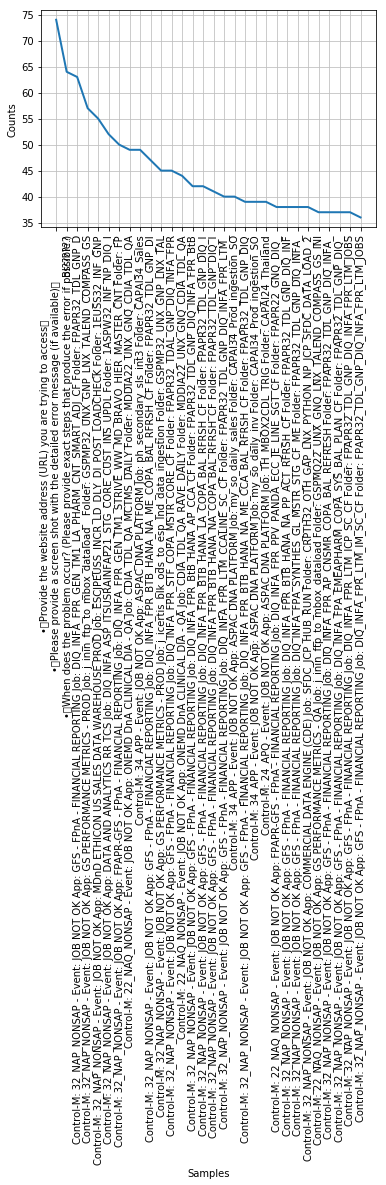

In [30]:
count = nltk.FreqDist(data.Description.values)
count.plot(30)

In [31]:
final_doc = data['Description']
all_documents = tuple(final_doc)

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(all_documents)
print (tfidf_matrix.shape)
print(tfidf_matrix)

(44990, 44806)
  (0, 22526)	0.1394771522285843
  (0, 18849)	0.20174414174788222
  (0, 4450)	0.4767464429748641
  (0, 22504)	0.20132246026762377
  (0, 40934)	0.2843653124141874
  (0, 43199)	0.21123696259371177
  (0, 41254)	0.1058364038946658
  (0, 40918)	0.26887823872065686
  (0, 17063)	0.21085535111957993
  (0, 6043)	0.6469822295599362
  (1, 17217)	0.1469460639898544
  (1, 5788)	0.16819373767278345
  (1, 21516)	0.14843530084745102
  (1, 27916)	0.24732031825896658
  (1, 32248)	0.11266241199149221
  (1, 32616)	0.14815702052146892
  (1, 12993)	0.1434434191972356
  (1, 32700)	0.27972792866876084
  (1, 19857)	0.239669998582686
  (1, 16235)	0.35163539650395564
  (1, 18716)	0.34854146351734444
  (1, 34816)	0.20809312607448657
  (1, 15685)	0.42989913107079947
  (1, 22493)	0.14717503533302181
  (1, 30572)	0.4255625418246086
  :	:
  (44988, 18028)	0.3310769132075292
  (44988, 23579)	0.30750733839226624
  (44988, 26224)	0.4328774462568097
  (44988, 16764)	0.4234318866555759
  (44988, 16024)	0.403

In [33]:
reindexed_data= data["Description"]

data_text = data[['Description']]
data_text['index'] = data_text.index
documents=data_text


print(len(documents))
print(documents[:5])

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk


def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

44990
                                             Description  index
24537  For dim_slt_id=2316, following tasks violated ...  24537
48264  Control-M: 32_NAP_NONSAP - Event: JOB NOT OK A...  48264
30708  I have the required user acess rights to AWSAD...  30708
24077  When did this issue begin?:\r\n\r\nWho is this...  24077
12562  GFS-FP&A-FINANCIAL PLANNING TM1 Finance GRM TM...  12562


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [34]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
stemmer.stem('identified')


doc_sample = documents[documents['index'] == 2].values[0][0]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))


processed_docs = documents['Description'].map(preprocess)
processed_docs[:5]

original document: 
['For', 'DIM_SLT_ID=203,', 'following', 'task(s)', 'violated', 'the', 'TASK_END_DELAY', 'constraint-\n\nDIM_TASK_ID:', '1636\nTASK_NAME:', 's_m_MENTOR_INT_MNT_LOT_MASTER\nSTART_TIME:', '2019-08-24', '06:02:00', 'UTC\nEND_TIME:', '2019-08-24', '06:03:00', 'UTC\n']


 tokenized and lemmatized document: 
['dim_slt_id', 'follow', 'task', 'violat', 'task_end_delay', 'constraint', 'dim_task_id', 'task_nam', 'start_tim', 'end_tim']


24537    [dim_slt_id, follow, task, violat, task_end_de...
48264    [control, event, onemd, clinic, prod, cdia_rav...
30708    [requir, user, ace, right, awsadwirl, awsadwir...
24077    [issu, begin, affect, mobil, issu, map, defaul...
12562    [financi, plan, financ, prod, gaap, incom, dif...
Name: Description, dtype: object

## LDA with Gensim:

### Create a dictionary from the data, then convert to bag-of-words corpus and save the dictionary and corpus for future use.

In [35]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 constraint
1 dim_slt_id
2 follow
3 task
4 task_end_delay
5 violat
6 cdia_rave_load
7 clinic
8 control
9 event
10 folder


In [36]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[123]

[(35, 1),
 (122, 1),
 (125, 1),
 (152, 1),
 (155, 1),
 (161, 5),
 (176, 1),
 (205, 1),
 (233, 1),
 (266, 1),
 (423, 1),
 (459, 1),
 (469, 2),
 (470, 1),
 (471, 1),
 (472, 1),
 (473, 1),
 (474, 1),
 (475, 1),
 (476, 1)]

In [37]:
#Preview Bag Of Words for our sample preprocessed document.
bow_doc_123 = bow_corpus[123]
for i in range(len(bow_doc_123)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_123[i][0], 
                                               dictionary[bow_doc_123[i][0]], 
bow_doc_123[i][1]))

Word 35 ("issu") appears 1 time.
Word 122 ("tool") appears 1 time.
Word 125 ("creat") appears 1 time.
Word 152 ("softwar") appears 1 time.
Word 155 ("chang") appears 1 time.
Word 161 ("file") appears 5 time.
Word 176 ("current") appears 1 time.
Word 205 ("work") appears 1 time.
Word 233 ("bold") appears 1 time.
Word 266 ("output") appears 1 time.
Word 423 ("problem") appears 1 time.
Word 459 ("tableau") appears 1 time.
Word 469 ("alteryx") appears 2 time.
Word 470 ("corrupt") appears 1 time.
Word 471 ("place") appears 1 time.
Word 472 ("review") appears 1 time.
Word 473 ("sure") appears 1 time.
Word 474 ("use") appears 1 time.
Word 475 ("visual") appears 1 time.
Word 476 ("workflow") appears 1 time.


In [38]:
#TF-IDF
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.3897979378120952),
 (1, 0.36610326418085787),
 (2, 0.3600782695614247),
 (3, 0.374785131814939),
 (4, 0.5407218030161777),
 (5, 0.38926294986371585)]


### Finding out 5 topics using LDA

In [39]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=5, id2word=dictionary, passes=2, workers=2)

In [40]:
# Print the results
import pickle

# Here we can assign topic names to each topic list, you can specify the number of words you want to have shown (e.g num_words = 5)
result = lda_model.print_topics(num_topics=5, num_words=5)
print(result)

for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

[(0, '0.061*"task" + 0.055*"follow" + 0.050*"fail" + 0.044*"statu" + 0.043*"dim_task_id"'), (1, '0.022*"access" + 0.019*"http" + 0.019*"user" + 0.014*"error" + 0.012*"attach"'), (2, '0.041*"fail" + 0.037*"error" + 0.025*"idiscov" + 0.021*"start_tim" + 0.021*"end_tim"'), (3, '0.143*"folder" + 0.140*"control" + 0.136*"event" + 0.065*"report" + 0.059*"financi"'), (4, '0.086*"issu" + 0.073*"troubleshoot" + 0.042*"busi" + 0.039*"impact" + 0.038*"step"')]
Topic: 0 
Words: 0.061*"task" + 0.055*"follow" + 0.050*"fail" + 0.044*"statu" + 0.043*"dim_task_id" + 0.042*"dim_slt_id" + 0.037*"violat" + 0.037*"constraint" + 0.036*"task_nam" + 0.023*"end_tim"
Topic: 1 
Words: 0.022*"access" + 0.019*"http" + 0.019*"user" + 0.014*"error" + 0.012*"attach" + 0.011*"data" + 0.010*"request" + 0.010*"need" + 0.009*"report" + 0.009*"unabl"
Topic: 2 
Words: 0.041*"fail" + 0.037*"error" + 0.025*"idiscov" + 0.021*"start_tim" + 0.021*"end_tim" + 0.020*"task_nam" + 0.020*"dim_task_id" + 0.018*"code" + 0.015*"java" +

In [41]:
# put these in a file and name the topics
with open("lda_topics_result.txt", "w") as f:
    for s in result:
        f.write(str(s) +"\n")

### pyLDAvis help to interpret the topics in a topic model that has been fit to a corpus of text data

In [42]:
# Visualize
import pyLDAvis.gensim

lda_display = pyLDAvis.gensim.prepare(lda_model, bow_corpus,dictionary, sort_topics=True)
pyLDAvis.display(lda_display)

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [43]:
from collections import OrderedDict

data_lda = {i: OrderedDict(lda_model.show_topic(i,25)) for i in range(5)}

In [44]:
import pandas as pd

df_lda = pd.DataFrame(data_lda)
print(df_lda.shape)
df_lda = df_lda.fillna(0).T
print(df_lda.shape)

(104, 5)
(5, 104)


In [45]:
df_lda

,abl,access,account,affect,ajsroot,analyt,apach,applic,aspac,assign,...,tri,troubleshoot,unabl,updat,user,violat,visibl,vison,websit,work
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.036965,0.000000,0.000000,0.000000,0.000000
1,0.005751,0.021742,0.007813,0.000000,0.000000,0.000000,0.000000,0.006528,0.000000,0.000000,...,0.006295,0.000000,0.008836,0.006037,0.018832,0.000000,0.000000,0.000000,0.005782,0.006716
2,0.000000,0.000000,0.000000,0.000000,0.012833,0.000000,0.011986,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.006246,0.000000,0.000000,0.032169,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004741,0.004155,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.037704,0.000000,0.000000,0.000000,0.000000,0.000000,0.005951,...,0.000000,0.073436,0.000000,0.000000,0.013348,0.000000,0.000000,0.000000,0.000000,0.000000


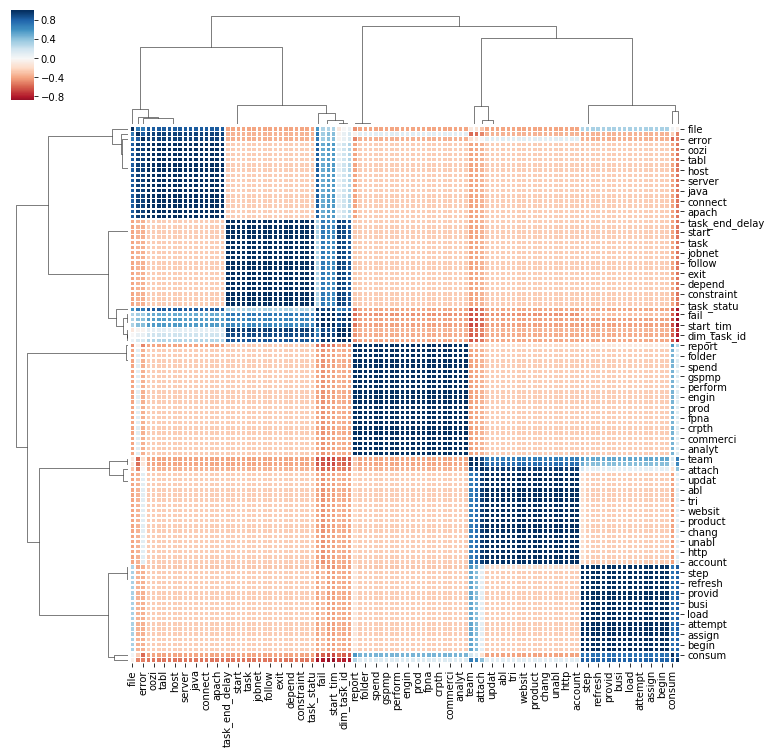

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

g=sns.clustermap(df_lda.corr(), center=0, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(12, 12))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

In [47]:
MAX_LENGTH = 500
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.Description.values)
post_seq = tokenizer.texts_to_sequences(data.Description.values)
post_seq_padded = pad_sequences(post_seq, maxlen=MAX_LENGTH)

In [48]:
def data_set_split (y):
    X_train, X_test, y_train, y_test = train_test_split(post_seq_padded, y, test_size=0.3,random_state=42)
    return X_train, X_test, y_train, y_test

In [49]:

vocab_size = len(tokenizer.word_index) + 1

## Deep Learning Model Simple

In [50]:
from sklearn.externals import joblib

In [51]:
def model_training(num_class, model_file):    
    inputs = Input(shape=(MAX_LENGTH, ))
    embedding_layer = Embedding(vocab_size,
                            128,
                            input_length=MAX_LENGTH)(inputs)
    x = Flatten()(embedding_layer)
    x = Dense(32, activation='relu')(x)
    predictions = Dense(num_class, activation='softmax')(x)
    model = Model(inputs=[inputs], outputs=predictions)
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
    model.summary()
    checkpointer = ModelCheckpoint(model_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    history = model.fit([X_train], batch_size=124, y=to_categorical(y_train), verbose=1, validation_split=0.25, 
          shuffle=True, epochs=10, callbacks=[checkpointer])
    
    df = pd.DataFrame({'epochs':history.epoch, 'accuracy': history.history['acc'], 'validation_accuracy': history.history['val_acc']})
    g = sns.pointplot(x="epochs", y="accuracy", data=df, fit_reg=False)
    g = sns.pointplot(x="epochs", y="validation_accuracy", data=df, fit_reg=False, color='green')
    
    return model

### Training Model to predict Priority of the ticket

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 500, 128)          5661312   
_________________________________________________________________
flatten_1 (Flatten)          (None, 64000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2048032   
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 7,709,410
Trainable params: 7,709,410
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 236

['model-simple_prt.pkl']

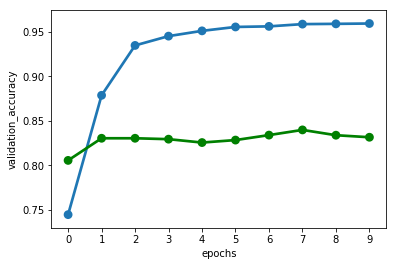

In [52]:
X_train, X_test, y_train, y_test = data_set_split(y_prt)

model_file = 'weights-simple_ptr.hdf5'
model = model_training(num_class_prt, model_file)
joblib.dump(model,'model-simple_prt.pkl')

In [53]:
predicted = model.predict(X_test)
predicted = np.argmax(predicted, axis=1)
accuracy_score(y_test, predicted)

0.8247017855819812

In [54]:
# This utility function is from the sklearn docs: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

In [55]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import itertools

In [56]:
# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
encoder.fit(data.Priority.values)
text_labels = encoder.classes_ 


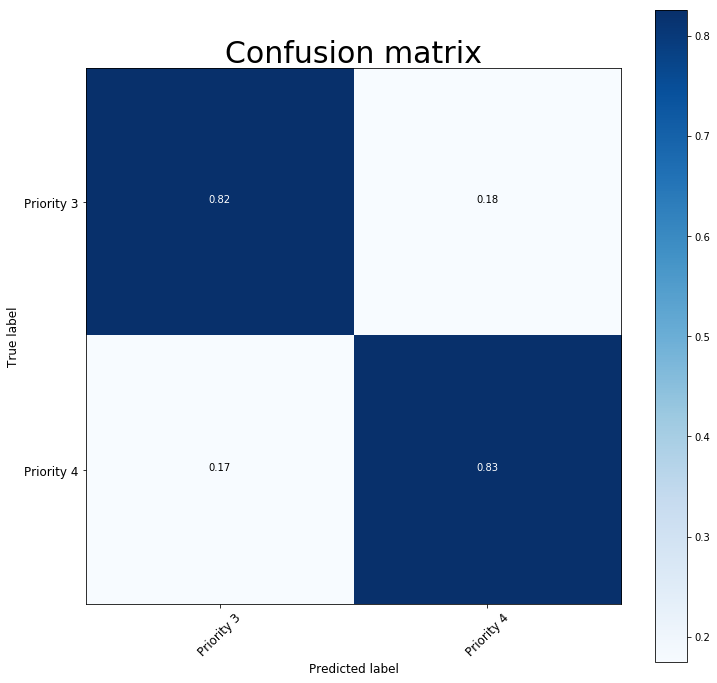

In [57]:
cnf_matrix = confusion_matrix(y_test, predicted)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()

## RNN with LSTM Layer

In [129]:
def lstm_model_training(num_class, model_file): 
    inputs = Input(shape=(MAX_LENGTH, ))
    embedding_layer = Embedding(vocab_size,
                                128,
                                input_length=MAX_LENGTH)(inputs)
    x = LSTM(64)(embedding_layer)
    x = Dense(32, activation='relu')(x)
    predictions = Dense(num_class, activation='softmax')(x)
    model_lstm = Model(inputs=[inputs], outputs=predictions)
    model_lstm.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['acc'])
    model_lstm.summary()

    checkpointer = ModelCheckpoint(model_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    history = model_lstm.fit([X_train], batch_size=64, y=to_categorical(y_train), verbose=1, validation_split=0.25, 
                             shuffle=True, epochs=20, callbacks=[checkpointer])
    
    df = pd.DataFrame({'epochs':history.epoch, 'accuracy': history.history['acc'], 'validation_accuracy': history.history['val_acc']})
    g = sns.pointplot(x="epochs", y="accuracy", data=df, fit_reg=False)
    g = sns.pointplot(x="epochs", y="validation_accuracy", data=df, fit_reg=False, color='green')
    return model_lstm


### Training Predictor for Priority using LSTM RNN 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 500, 128)          5661312   
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 66        
Total params: 5,712,866
Trainable params: 5,712,866
Non-trainable params: 0
_________________________________________________________________
Train on 32055 samples, validate on 10685 samples
Epoch 1/20
32055/32055 [==============================] - 247s 8ms/step - loss: 0.

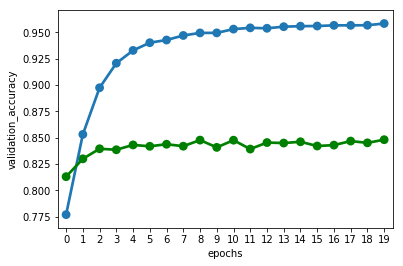

In [130]:
X_train, X_test, y_train, y_test = data_set_split(y_prt)
model_lstm = lstm_model_training(num_class_prt,"weights_prt.hdf5")
joblib.dump(model_lstm,'model_ptr.pkl')
predicted = model_lstm.predict(X_test)

In [131]:
predicted
predicted = np.argmax(predicted, axis=1)
accuracy_score(y_test, predicted)

0.8373333333333334

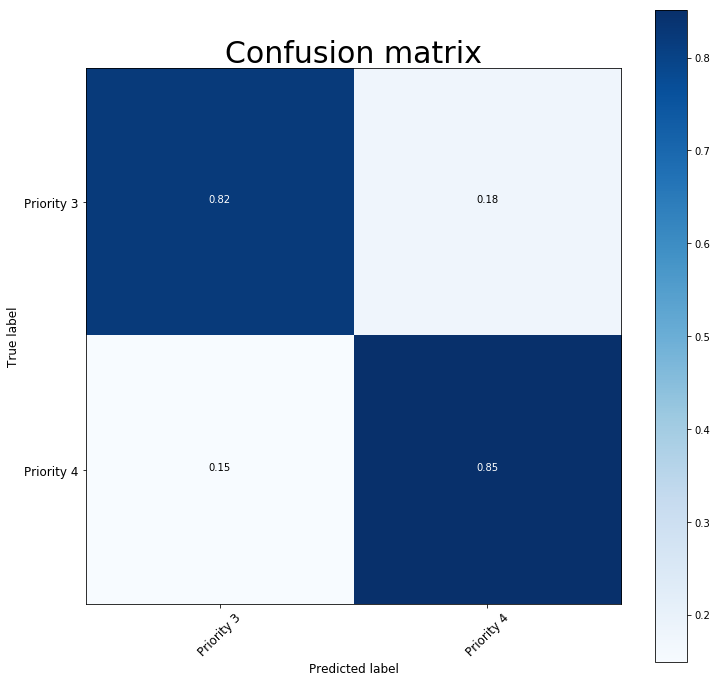

In [132]:
cnf_matrix = confusion_matrix(y_test, predicted)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()

In [133]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.85      0.82      0.83      1121
           1       0.83      0.85      0.84      1129

   micro avg       0.84      0.84      0.84      2250
   macro avg       0.84      0.84      0.84      2250
weighted avg       0.84      0.84      0.84      2250

